In [ ]:
%pip install matplotlib
%pip install numpy
%pip install opencv-python
%pip install anglr

In [1]:
import sys, time
sys.path.insert(0, '../src')

from robot import Robot

import matplotlib.pyplot as plt
import numpy as np
import vrep
import math

from anglr import Angle
from datetime import datetime

In [2]:
class Kinematic_model:
    def __init__(self,robot):
        self.robot = robot
        
        #Handles dos motores
        ret1, self.motorLeft = vrep.simxGetObjectHandle(self.robot.clientID, "Pioneer_p3dx_leftMotor", vrep.simx_opmode_oneshot_wait)
        ret2, self.motorRight = vrep.simxGetObjectHandle(self.robot.clientID, "Pioneer_p3dx_rightMotor", vrep.simx_opmode_oneshot_wait)
        
        #Calcula distancia de eixo
        res, left_handle = vrep.simxGetObjectHandle(robot.clientID, "Pioneer_p3dx_leftMotor", vrep.simx_opmode_oneshot_wait)
        ret, lpos = vrep.simxGetObjectPosition(robot.clientID, left_handle, robot.robot_handle, vrep.simx_opmode_oneshot_wait)
        
        res, right_handle = vrep.simxGetObjectHandle(robot.clientID, "Pioneer_p3dx_rightMotor", vrep.simx_opmode_oneshot_wait)
        ret, rpos = vrep.simxGetObjectPosition(robot.clientID, right_handle, robot.robot_handle, vrep.simx_opmode_oneshot_wait)
        
        # eixo
        self.l = (abs(lpos[1]) + abs(rpos[1]))/2
        
        #Ao ser criado, coleta a referencia de zero do robo
        pos = self.robot.get_current_position()
        self.initial_pos_x = pos[0]
        self.initial_pos_y = pos[1]
        orientation = self.robot.get_current_orientation()
        self.initial_orientation = orientation[2]

        #Alem de mantermos a pose inicial, manteremos a pose atualizada do robo
        self.enc_global_x = self.initial_pos_x
        self.enc_global_y = self.initial_pos_y
        self.enc_Theta = self.initial_orientation
        
        self.time_global_x = self.initial_pos_x
        self.time_global_y = self.initial_pos_y
        self.time_Theta = self.initial_orientation
        
        #Lista de pontos para o caminho do robo
        self.enc_path = []
        self.time_path = []
        self.true_path = []
        self.update_paths()
        
        #inicializando a posição dos encoders
        self.jL = self.current_encoder_left()
        self.jR = self.current_encoder_right()
        
        #intervalo entre cada calculo
        self.compute_interval = 0.1
        self.previous_timestamp = 0
        
    def update_paths(self):
        self.enc_path.append([self.enc_global_x, self.enc_global_y, self.enc_Theta])
        self.time_path.append([self.time_global_x, self.time_global_y, self.time_Theta])
        orientation = self.robot.get_current_orientation()
        true_theta = orientation[2]
        current_position = self.true_global_position()
        self.true_path.append([current_position[0], current_position[1], true_theta])
    
    def true_global_position(self):
        pos = self.robot.get_current_position()
        return pos[0],pos[1]
    
    def enc_global_position(self):
        return self.enc_global_x, self.enc_global_y, self.enc_Theta
    
    def time_global_position(self):
        return self.time_global_x, self.time_global_y, self.time_Theta
    
    
    ##Esta seção esta relacionada ao calculo da posição levando em consideração os encoders
    def current_encoder_left(self):
        ret,jL = vrep.simxGetJointPosition(self.robot.clientID,self.motorLeft,vrep.simx_opmode_oneshot_wait)
        return jL
    def current_encoder_right(self):
        ret, jR = vrep.simxGetJointPosition(self.robot.clientID,self.motorRight,vrep.simx_opmode_oneshot_wait)
        return jR
        
    #Phi speed of rotation of wheels
    def Xr(self, Phi_right, Phi_left):
        r = self.robot.WHEEL_RADIUS
        Xr = (r*Phi_left/2) + (r*Phi_right/2)
        return Xr
    
    def Theta_r(self, Phi_right, Phi_left):
        r = self.robot.WHEEL_RADIUS
        Tr = r*Phi_right/(2*self.l) - r*Phi_left/(2*self.l) 
        return Tr
        
    def speed_model(self,Phi_right,Phi_left):
        #Se formos considerar que o eixo das rodas do robo está deslocado do eixo x
        #return np.array([self.Xr(Phi_right,Phi_left),self.Theta_r(Phi_right,Phi_left)*self.l2,self.Theta_r(Phi_right,Phi_left)])
        return np.array([self.Xr(Phi_right,Phi_left),0,self.Theta_r(Phi_right,Phi_left)])
        
    def inverse_rotation_matrix(self, ang):
        Trot = np.array([[math.cos(ang), -math.sin(ang), 0], [math.sin(ang), math.cos(ang), 0], [0,0,1]])
        return Trot
    
    def locomotion_global(self, ang, Phi_right, Phi_left):
        return np.dot(self.inverse_rotation_matrix(ang),self.speed_model(Phi_right,Phi_left))
    
    def compute_with_encoder(self):
        dxR = self.current_encoder_right() - self.jR
        dxL = self.current_encoder_left() - self.jL
        if (dxL>=0):
            dxL=math.fmod(dxL+math.pi,2*math.pi)-math.pi
        else:
            dxL=math.fmod(dxL-math.pi,2*math.pi)+math.pi
        if (dxR>=0):
            dxR=math.fmod(dxR+math.pi,2*math.pi)-math.pi
        else:
            dxR=math.fmod(dxR-math.pi,2*math.pi)+math.pi
        qsi = self.locomotion_global(self.enc_Theta,dxR, dxL)
        #Atualiza a posição global
        self.enc_global_x = self.enc_global_x + qsi[0]
        self.enc_global_y = self.enc_global_y + qsi[1]
        self.enc_Theta = self.enc_Theta + qsi[2]
        #Atualiza a posição dos encoders
        self.jR = self.current_encoder_right()
        self.jL = self.current_encoder_left()
    ##Fim da seção relacionada ao calculo da posição levando em consideração os encoders        
    
    def compute_with_time(self, Phi_right, Phi_left):
        #Calculo do delta S
        r = self.robot.WHEEL_RADIUS
        Vr = r*Phi_right
        Vl = r*Phi_left
        current_timestamp = datetime.timestamp(datetime.now())
        Delta_t = current_timestamp - self.previous_timestamp
        #atualiza timestamp imediatamente

        self.previous_timestamp = current_timestamp
        
        Delta_s = (Vr + Vl)*Delta_t/2  
        Delta_Theta = (Vr - Vl)*Delta_t/(2*self.l)
    
        self.time_global_x = self.time_global_x + Delta_s*math.cos(self.time_Theta + Delta_Theta/2)
        self.time_global_y = self.time_global_y + Delta_s*math.sin(self.time_Theta + Delta_Theta/2)
        self.time_Theta = self.time_Theta + Delta_Theta
    
    def move(self,Phi_right, Phi_left,seconds): #velocidade em rad/s
        #Vamos fixar um tempo de 500ms para computar as distâncias
        for step in range(int(seconds/self.compute_interval)):
            #self.compute()
            self.robot.set_right_velocity(Phi_right)
            self.robot.set_left_velocity(Phi_left)
            time.sleep(self.compute_interval)
            self.compute_with_encoder()
            self.compute_with_time(Phi_right, Phi_left)
            self.update_paths()
        self.robot.stop()
        self.timestamp = 0
        
    def turnGlobal(self, input_ang):
        orientation = self.robot.get_current_orientation()[2]
        ang = input_ang
        if (orientation < 0):
            orientation = orientation + 2*math.pi
        if (ang < 0):
            ang = ang + 2*math.pi
            
        print("Initial orientation ", orientation)
        print("Ang ", ang)
        vel = 0.2
        
        if ((ang - orientation) > math.pi) or (0 > (ang - orientation) > -math.pi):
            vel = - vel
        
        self.robot.set_right_velocity(vel)
        self.robot.set_left_velocity(-vel)
        tolerance = math.pi/90
        while ((ang - orientation) > tolerance) or ((ang - orientation) < -tolerance):
            time.sleep(0.05)
            orientation = self.robot.get_current_orientation()[2]
            if (orientation < 0):
                orientation = orientation + 2*math.pi
            sys.stdout.write("\r" + "Diff " + str((ang - orientation)) + " orientation " + str(orientation))
            sys.stdout.flush()
        self.robot.stop()
        print("curr orientation ", orientation)
    
    def ICR_left(self, Phi_left, R, seconds):
        Phi_right = Phi_left*(R + self.l)/(R - self.l)
        print("ICR_left Phi_r {} Phi_l {}".format(Phi_right, Phi_left))
        self.move(Phi_right, Phi_left, seconds)
    
    def ICR_right(self, Phi_right, R, seconds):
        Phi_left = Phi_right*(R + self.l)/(R - self.l)
        print("ICR_right Phi_r {} Phi_l {}".format(Phi_right, Phi_left))
        self.move(Phi_right, Phi_left, seconds)
  
    def plot_paths(self):
        enc_path = np.array(self.enc_path)
        time_path = np.array(self.time_path)
        true_path = np.array(self.true_path)
        
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        ax[0].scatter(enc_path[:,0], enc_path[:,1], 5, c='b', marker='o')
        #ax[1].scatter(time_path[:,0], time_path[:,1], 5, c='g', marker='o')
        ax[1].scatter(true_path[:,0], true_path[:,1], 5, c='r', marker='o')

In [3]:
class Laser_sensor:
    def __init__(self,robot):
        self.robot = robot

    def update_robot_frame_reading(self):
        laser_flatten_readings = np.array(self.robot.read_laser())
        laser_readings = laser_flatten_readings.reshape((len(laser_flatten_readings)//3, 3))
        self.laser_x = laser_readings[:,0]
        self.laser_y = laser_readings[:,1]

class Us_sensor:
    def __init__(self,robot):
        orientation_angles = np.array([90,50,30,10,-10,-30,-50,-90,-90,-130,-150,-170,170,150,130,90])
        orientation_rad = np.radians(orientation_angles)
        self.data = {
        "prefix" : "Pioneer_p3dx_ultrasonicSensor",
        "ids" : np.arange(1,17,1), "handles" : np.zeros(16, dtype=int), 
        "positions" :  np.zeros((16,3),dtype=float),
        "angles_deg": orientation_angles,
        "angles_rad": orientation_rad,
        "raw_reading": np.zeros(16),
        "robot_frame_reading": np.zeros((16,2),dtype=float)
        }
        self.robot = robot
        
        for i,sensor_i in enumerate(self.data['ids']):
            ret,handle = vrep.simxGetObjectHandle(self.robot.clientID, self.data['prefix'] + str(sensor_i), vrep.simx_opmode_oneshot_wait)
            self.data['handles'][i] = handle
            ret, pos = vrep.simxGetObjectPosition(self.robot.clientID, handle, self.robot.robot_handle, vrep.simx_opmode_oneshot_wait)
            #ret, ang = vrep.simxGetObjectOrientation(robot.clientID, handle, robot.robot_handle, vrep.simx_opmode_oneshot_wait)
            self.data['positions'][i,:] = pos
            #ultrassonic_sensors[sensor_i,4:7] = ang
            
    def get_left_distance(self):
        self.update_raw_reading()
        #return np.min(np.array([self.data["raw_reading"][0],self.data["raw_reading"][1],self.data["raw_reading"][15],self.data["raw_reading"][14]]))
        return np.array(self.data["raw_reading"][0])
    
    def get_front_distance(self):
        self.update_raw_reading()
        return np.min(np.array([self.data["raw_reading"][2:6]]))
        #return np.min(np.array([self.data["raw_reading"][2:4]]))
    
    def get_right_distance(self):
        self.update_raw_reading()
        return np.min(np.array([self.data["raw_reading"][6:10]]))
    
    def update_raw_reading(self):
        self.data["raw_reading"] = np.array(self.robot.read_ultrassonic_sensors())
    
    def update_robot_frame_reading(self):
        self.update_raw_reading()
        for i, proximity in enumerate(us_sensors.data["raw_reading"]):
            if proximity == 5 or proximity < 0.1:
                self.data["robot_frame_reading"][i] = np.zeros(2)
            else:
                self.data["robot_frame_reading"][i] = self.proximity_robot_frame(i+1,proximity).flatten()
                
        #toRobotFrame = lambda sensorId,proximity: self.proximity_robot_frame(sensorId,proximity)
        #self.data["robot_frame_reading"] = toRobotFrame(range(1,17,1),us_sensors.data["raw_reading"])
    
    #Calcula o ponto no frame do robo, referente a leitura de cada sensor de proximidade
    def proximity_robot_frame(self,sensorId, proximity):
        index = sensorId -1
        angulars = self.data["angles_rad"][index]
        #Matriz de rotação
        rot_matrix = np.array([[math.cos(angulars),-math.sin(angulars)],[math.sin(angulars),math.cos(angulars)]])
        #Rotacionando a leitura
        distXY = np.dot(rot_matrix , np.array([[proximity],[0]]))
        #Matriz de translação
        posicao_sensor_x = self.data["positions"][index][0]
        posicao_sensor_y = self.data["positions"][index][1]
        transXY=np.array([[distXY[0][0]+posicao_sensor_x],[distXY[1][0]+posicao_sensor_y]])
        return transXY

class PointCloud():
    def __init__(self, robot, us_sensors, laser_sensor):
        self.robot = robot
        self.us_sensors = us_sensors
        self.laser_sensor = laser_sensor
        
        self.ultrassonic_points = []
        self.laser_points = []
        self.robot_points = []
    
    def update(self):
        #Insere posição atual do robo
        robot_x = self.robot.get_current_position()[0]
        robot_y = self.robot.get_current_position()[1]
        robot_ang = self.robot.get_current_orientation()[2]
        
        self.robot_points.append([robot_x,robot_y])

        #Atualiza a leitura do laser e insere na nuvem de pontos
        self.laser_sensor.update_robot_frame_reading()
        for pointx, pointy in zip(self.laser_sensor.laser_x, self.laser_sensor.laser_y):
            x,y = toGlobal(robot_x, robot_y,robot_ang, pointx, pointy)
            self.laser_points.append([x,y])

        #Atualiza a leitura do ultrassonico e insere na nuvem de pontos
        self.us_sensors.update_robot_frame_reading()
        for pointx, pointy in zip(self.us_sensors.data['robot_frame_reading'][:,0], self.us_sensors.data['robot_frame_reading'][:,1]):
            x,y = toGlobal(robot_x, robot_y,robot_ang, pointx, pointy)
            self.ultrassonic_points.append([x,y])
    
    def plot_point_cloud(self):
        #Convertendo a nuvem de pontos em um array
        ultrassonic_point_array = np.array(self.ultrassonic_points)
        laser_point_array = np.array(self.laser_points)
        robot_path = np.array(self.robot_points)

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
        #posição do centro do robo
        ax[0].scatter(robot_path[:,0], robot_path[:,1], 40, c='b', marker='o')
        #ax[0].plot(robot_path[:,0], robot_path[:,1],'.-')
        pass_count = 0
        for x, y in zip(robot_path[:,0], robot_path[:,1]):
            ax[0].text(x, y, str(pass_count), color="black", fontsize=12)
            pass_count += 1
        #posição dos pontos lidos pelo sensor ultrassonico
        ax[0].scatter(ultrassonic_point_array[:,0],ultrassonic_point_array[:,1], 10, c='magenta', marker='.')

        #posição do centro do robo
        ax[1].scatter(robot_path[:,0], robot_path[:,1], 40, c='b', marker='o')
        #ax[1].plot(robot_path[:,0], robot_path[:,1],'.-')
        pass_count = 0
        for x, y in zip(robot_path[:,0], robot_path[:,1]):
            ax[1].text(x, y, str(pass_count), color="black", fontsize=12)
            pass_count += 1
        #posição dos pontos lidos pelo sensor laser
        ax[1].scatter(laser_point_array[:,0],laser_point_array[:,1], 10, c='r', marker='.')

        plt.show()

class PID():
    def __init__(self, P=1, I=0.0, D=0.0, Derivator=0, Integrator=0, Integrator_max=500, Integrator_min=-500):
        self.Kp=P
        self.Ki=I
        self.Kd=D
        self.Derivator=Derivator
        self.Integrator=Integrator
        self.Integrator_max=Integrator_max
        self.Integrator_min=Integrator_min
        self.set_point=0.0
        self.error=0.0

    def update(self,current_value):
        self.error = self.set_point - current_value
        self.P_value = self.Kp * self.error
        self.D_value = self.Kd * ( self.error - self.Derivator)
        self.Derivator = self.error
        self.Integrator = self.Integrator + self.error

        if self.Integrator > self.Integrator_max:
            self.Integrator = self.Integrator_max
        elif self.Integrator < self.Integrator_min:
            self.Integrator = self.Integrator_min

        self.I_value = self.Integrator * self.Ki

        PID = self.P_value + self.I_value + self.D_value
        print("PID cv ",current_value ," sp ", self.set_point ," error ", self.error ," pid ", PID)
        return PID

    def setPoint(self,set_point):
        self.set_point = set_point
        self.Integrator=0
        self.Derivator=0

In [4]:
def toGlobal(robot_x, robot_y,robot_ang, Point_xr, Point_yr):
    T_trans = np.array([[1,0,robot_x],[0,1,robot_y],[0,0,1]])
    T_rot = np.array([[math.cos(robot_ang),-math.sin(robot_ang),0],[math.sin(robot_ang),math.cos(robot_ang),0],[0,0,1]])
    T = np.dot(T_trans,T_rot)
    res = np.dot(T, np.array([Point_xr,Point_yr,1]))
    return res[0],res[1]

def plot_lase_robot_frame():
    fig, ax = plt.subplots()
    #posição dos feixes laser
    ax.scatter(laser_sensor.laser_x, laser_sensor.laser_y, 3, c='g', marker='o')
    #posição do centro do robo
    ax.scatter(0, 0, 40, c='b', marker='o')
    plt.show()

def fromGlobal(robot_x, robot_y,robot_ang, Point_xr, Point_yr):
    T_trans = np.array([[1,0,-robot_x],[0,1,-robot_y],[0,0,1]])
    T_rot = np.array([[math.cos(robot_ang),math.sin(robot_ang),0],[-math.sin(robot_ang),math.cos(robot_ang),0],[0,0,1]])
    T = np.dot(T_rot,T_trans)
    res = np.dot(T, np.array([Point_xr,Point_yr,1]))
    ang = np.arctan2(res[1],res[0])
    return res[0],res[1], ang

### -------------------------------------------------------------------------------------------------------------------------------------------------------
### ---------------------------------------------------------  CÓDIGO PARA EDIÇÃO  ----------------------------------------------------------
### -------------------------------------------------------------------------------------------------------------------------------------------------------

In [5]:
class MobileRobot():
    def __init__(self):
        self.go_x = 0
        self.go_y = 0
        self.robot = Robot()
        self.kinematicModel = Kinematic_model(self.robot)
        self.us_sensors = Us_sensor(self.robot)
        self.laser_sensors = Laser_sensor(self.robot)
        self.pidL = PID()
        self.pidL.setPoint(0.5)
#         self.pidF = PID()
#         self.pidF.setPoint(1)
        self.compute_interval = 0.5
        self.follow_wall_side = "LEFT"
        
        self.curr_state = None
        self.prev_state = None
        
    def checkCurrentState(self):
        previous_state = self.curr_state
        left = self.us_sensors.get_left_distance()
        right = self.us_sensors.get_right_distance()
        front = self.us_sensors.get_front_distance()
        
        #Initial state: Move Foward
        if (previous_state == None and self.prev_state == None):
            self.curr_state = 'CalcDirection'
        
        #CD -> MF
        if (previous_state == 'CalcDirection' and front >= 0.5):
            self.curr_state = 'MoveFoward'
        
        #MF->TR
        if (previous_state == 'MoveFoward' and front <= 0.5):
            self.curr_state = 'TurnRight'
            
        #TR->WF
        if (previous_state == 'TurnRight' and left <= 0.8):
            self.curr_state = 'WallFollow'
            
        #WF->TR
        if (previous_state == 'WallFollow' and front <= 0.5):
            self.curr_state = 'TurnRight'
            
        #WF->MoveFoward
        if (previous_state == 'WallFollow' and front == 5 and left > 0.7):
            self.curr_state = 'CalcDirection'
          
        #update prev
        self.prev_state = previous_state
    
    def control(self, left_distance, right_distance, front_distance ):
        left = self.us_sensors.get_left_distance()
        right = self.us_sensors.get_right_distance()
        front = self.us_sensors.get_front_distance()
        vel = 0
        turn = 0
        self.checkCurrentState()
        
        print("left ", left, "right ", right, "front ", front)
        
        #State Machine
        ##Move foward
        if (self.curr_state == 'MoveFoward'):
            turn = 0
            vel = 10
        ##Turn Right
        elif (self.curr_state == 'TurnRight'):
            turn = 10
            vel = 0
        #Wall Follow
        elif (self.curr_state == 'WallFollow'):
            turn = self.pidL.update(left_distance)
            vel = 10
        #Turn Back
#         elif (self.curr_state == 'TurnBack'):
#             turn = -1
#             vel = 0
        #Calc Direction
        elif (self.curr_state == 'CalcDirection'):
            self.go_x
            self.go_y
            
            turn = self.pidL.update(left_distance)
            vel = 10
        
        
        print("State: ", self.curr_state)
        self.prev_state = self.curr_state
        return vel + turn, vel - turn

    def start(self, seconds):
        for step in range(int(seconds/self.compute_interval)):
            #Phi_l, Phi_r = self.braitenberg(self.us_sensors.data["raw_reading"][:8],2)
            Phi_l, Phi_r = self.control(self.us_sensors.get_left_distance(),self.us_sensors.get_right_distance(), self.us_sensors.get_front_distance())
            self.kinematicModel.move(Phi_r, Phi_l,self.compute_interval)
            #self.kinematicModel.plot_paths()
            #self.point_cloud.update()
            #self.point_cloud.plot_point_cloud()
    
    def teste(self):
        give_diretion(self.robot, self.us_sensors, 0, 0)
        

In [6]:
def give_diretion(robot, us_sensors, go_point_x, go_point_y):
    
    # global position of robot
    robot_x = robot.get_current_position()[0]
    robot_y = robot.get_current_position()[1]
    robot_ang = robot.get_current_orientation()[2]
    
    # relative vector to goal
    vec_x_go = go_point_x - robot_x
    vec_y_go = go_point_y - robot_y
    
    # angle between position and goal vector
    #vector origin
    
    ang = math.acos( vec_x_go / ( math.sqrt(math.pow(vec_x_go,2)+math.pow(vec_y_go,2)) ) )

    print("ang:")
    print(ang)
    print("ang robot:")
    print(robot_ang)
    
    mr.kinematicModel.turnGlobal(ang)
    
    print("After:")
    print(robot.get_current_orientation()[2])
    
    # plot
    plt.plot([0,0],[-7.5,7.5], color='g')
    plt.plot([-7.5,7.5], [0,0], color='r')
    origin = [robot_x, robot_y]
    
    #plt.quiver(*origin, data1, data2, color=['b'], scale=30)
    #plt.quiver(*origin, vec_x_sum, vec_y_sum, color=['r'])
    plt.quiver(*origin, vec_x_go, vec_y_go, color=['g'])

    plt.axis([-7.5,7.5,-7.5,7.5])
    plt.show()
    
    # new direction [vector_x, vetor_y]
    #return [alpha * vec_x_go + (1 - alpha) * vec_x_sum, alpha * vec_y_go + (1 - alpha) * vec_y_sum, robot_x, robot_y]
        
#give_diretion(robot, us_sensors, 0, 0)

In [7]:
mr = MobileRobot()

Connected to remoteApi server.
 Pioneer_p3dx_ultrasonicSensor1 connected.
 Pioneer_p3dx_ultrasonicSensor2 connected.
 Pioneer_p3dx_ultrasonicSensor3 connected.
 Pioneer_p3dx_ultrasonicSensor4 connected.
 Pioneer_p3dx_ultrasonicSensor5 connected.
 Pioneer_p3dx_ultrasonicSensor6 connected.
 Pioneer_p3dx_ultrasonicSensor7 connected.
 Pioneer_p3dx_ultrasonicSensor8 connected.
 Pioneer_p3dx_ultrasonicSensor9 connected.
 Pioneer_p3dx_ultrasonicSensor10 connected.
 Pioneer_p3dx_ultrasonicSensor11 connected.
 Pioneer_p3dx_ultrasonicSensor12 connected.
 Pioneer_p3dx_ultrasonicSensor13 connected.
 Pioneer_p3dx_ultrasonicSensor14 connected.
 Pioneer_p3dx_ultrasonicSensor15 connected.
 Pioneer_p3dx_ultrasonicSensor16 connected.
 Vision sensor connected.
 Laser connected.
 Left motor connected.
 Right motor connected.
 Robot connected.


ang:
2.3676012543645752
ang robot:
2.3762197494506836
Initial orientation  2.3762197494506836
Ang  2.3676012543645752
curr orientation  2.3762197494506836
After:
2.3762176036834717


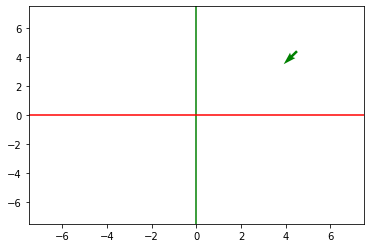

In [8]:
mr.teste()